# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/VanHoan-TRINH/COMP4471_Project

Cloning into 'COMP4471_Project'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 15), reused 35 (delta 1), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [3]:
cd COMP4471_Project

/content/COMP4471_Project


# Data

In [4]:
from models.classifier.dataset import prepare_data

data_dir = "/content/drive/MyDrive/Colab Notebooks/COMP4471/Project/facemask"

train_loader, val_loader, test_loader = prepare_data(data_dir=data_dir, verbose=True)

with_mask_dir train: 3400 valid: 300 test: 300
incorrect_mask_dir train: 4200 valid: 400 test: 400
without_mask_dir train: 3400 valid: 300 test: 300
train: (11000, 2)
                                            Filepath  Label
0  /content/drive/MyDrive/Colab Notebooks/COMP447...      0
valid: (1000, 2)
                                            Filepath  Label
0  /content/drive/MyDrive/Colab Notebooks/COMP447...      0
test: (1000, 2)
                                            Filepath  Label
0  /content/drive/MyDrive/Colab Notebooks/COMP447...      0
Dataset class: 11000 1000 1000 torch.Size([3, 224, 224]) tensor([0]) 2.5 -2.4880952373912018


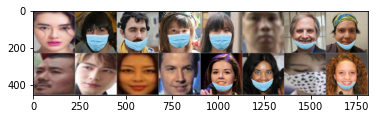

1:not wearing 2:correct 3:incorrect 4:correct 5:correct 6:not wearing 7:incorrect 8:incorrect 9:not wearing 10:not wearing 11:not wearing 12:not wearing 13:incorrect 14:incorrect 15:correct 16:incorrect


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from models.classifier.dataset import batch_size

id2label = {"0": "correct", "1": "incorrect", "2": "not wearing"}

# functions to show an image
def imshow(img):
    img = img * 0.2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' '.join(f'{j+1}:{id2label[str(labels.numpy()[j][0])]}' for j in range(batch_size)))

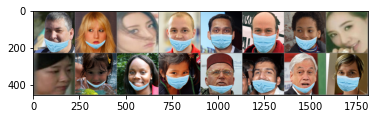

1:incorrect 2:incorrect 3:not wearing 4:incorrect 5:correct 6:correct 7:incorrect 8:not wearing 9:not wearing 10:incorrect 11:incorrect 12:correct 13:incorrect 14:incorrect 15:incorrect 16:correct


In [6]:
# get some random training images
dataiter = iter(val_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' '.join(f'{j+1}:{id2label[str(labels.numpy()[j][0])]}' for j in range(batch_size)))

# Model

In [8]:
import torch
from models.classifier.model import EfficientNet

num_examples, num_classes = 10, 5
inputs = torch.rand(10, 3, 224, 224)
model = EfficientNet.from_name('efficientnet-b0', num_classes=5)
model.eval()
model(inputs).shape # (num_examples, num_classes)

torch.Size([10, 5])

# Train

## utils

In [7]:
from sklearn.metrics import classification_report

def check_accuracy(loader, model):  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.squeeze(1).to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

def check_performance(loader, model):
    y_true = []
    y_pred = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.squeeze(1).to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            y_true += y.tolist()
            y_pred += preds.tolist()

    print(classification_report(y_true, y_pred, digits=4))
    
def print_num_params(model, display_all_modules=False):
    total_num_params = 0
    for n, p in model.named_parameters():
        num_params = 1
        for s in p.shape:
            num_params *= s
        if display_all_modules: print("{}: {}".format(n, num_params))
        total_num_params += num_params
    print("-" * 50)
    print("Total number of parameters: ", total_num_params)

def train(model, optimizer, epochs=1):
    """    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: history
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loss_train = []
    val_acc = []

    for e in range(epochs):
        print("Epoch: ", e)
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.squeeze(1).to(device=device, dtype=torch.long)

            scores = model(x)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy(val_loader, model)
                print()
                loss_train.append(loss.item())
                val_acc.append(acc)

            if t == 500:  # for demo purpose
                break
                
        # if log per epoch
        #loss_train.append(loss.item())
        #val_acc.append(acc)           

    return loss_train, val_acc

## load data

In [5]:
from models.classifier.dataset import prepare_data

data_dir = "/content/drive/MyDrive/Colab Notebooks/COMP4471/Project/facemask"
train_loader, val_loader, test_loader = prepare_data(data_dir)

## load model

In [9]:
USE_GPU = True
dtype = torch.float32 # We will use float torch

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [10]:
from models.classifier.model import EfficientNet

model = EfficientNet.from_name('efficientnet-b0', num_classes=3)

model_dir = "/content/drive/MyDrive/Colab Notebooks/COMP4471/Project/efficientnet-b0-ckpt4.pth"
model.load_state_dict(torch.load(model_dir))

print_num_params(model)

check_performance(val_loader, model.to(device))

--------------------------------------------------
Total number of parameters:  4011391
              precision    recall  f1-score   support

           0     0.9583    0.9967    0.9771       300
           1     0.9974    0.9650    0.9809       400
           2     0.9900    0.9933    0.9917       300

    accuracy                         0.9830      1000
   macro avg     0.9819    0.9850    0.9832      1000
weighted avg     0.9835    0.9830    0.9830      1000



## run

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

# control how frequently to print train loss.
print_every = 50
print('using device:', device)

using device: cuda


Keep the below cell for demo purpose

In [12]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay= 5e-4)
history = train(model, optimizer, epochs=1)

Epoch:  0
Iteration 0, loss = 0.0918
Got 983 / 1000 correct (98.30)

Iteration 50, loss = 0.0253
Got 984 / 1000 correct (98.40)

Iteration 100, loss = 0.0111
Got 984 / 1000 correct (98.40)

Iteration 150, loss = 0.3218
Got 985 / 1000 correct (98.50)

Iteration 200, loss = 0.0283
Got 985 / 1000 correct (98.50)

Iteration 250, loss = 0.1989
Got 985 / 1000 correct (98.50)

Iteration 300, loss = 0.0094
Got 984 / 1000 correct (98.40)

Iteration 350, loss = 0.0353
Got 984 / 1000 correct (98.40)

Iteration 400, loss = 0.0126
Got 985 / 1000 correct (98.50)

Iteration 450, loss = 0.0229
Got 984 / 1000 correct (98.40)

Iteration 500, loss = 0.0208
Got 984 / 1000 correct (98.40)



In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay= 5e-4)
history = train(model, optimizer, epochs=1)

## visualize

In [13]:
loss_train, val_acc = history
len(loss_train), len(val_acc)

(11, 11)

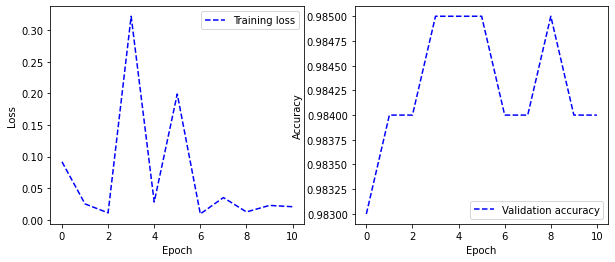

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss_train, label="Training loss", color="blue", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(val_acc, label="Validation accuracy", color="blue", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
check_performance(val_loader, model)

              precision    recall  f1-score   support

           0     0.9585    1.0000    0.9788       300
           1     1.0000    0.9650    0.9822       400
           2     0.9900    0.9933    0.9917       300

    accuracy                         0.9840      1000
   macro avg     0.9828    0.9861    0.9842      1000
weighted avg     0.9845    0.9840    0.9840      1000



## save

In [17]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/COMP4471/Project/efficientnet-b0-ckpt5.pth"
torch.save(model.state_dict(), model_dir)

## predict

0: with mask, 1: incorrect_mask, 2: without_mask


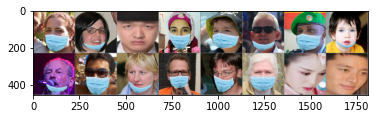

Predict: [0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2]
Labels: [0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2]
CPU times: user 581 ms, sys: 121 ms, total: 702 ms
Wall time: 729 ms


In [21]:
%%time
print("0: with mask, 1: incorrect_mask, 2: without_mask")
# get some random training images
dataiter = iter(val_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

# print predictions
images = images.to(device=device, dtype=dtype)  # move to device, e.g. GPU
scores = model(images)
_, preds = scores.max(1)
print("Predict:", preds.tolist())

# print labels
print("Labels:",labels.squeeze(1).tolist())

# Predict on the test set
Run once for reporting the final report

In [ ]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/COMP4471/Project/efficientnet-b0-ckpt5.pth"
model = EfficientNet.from_name('efficientnet-b0', num_classes=3)
model.load_state_dict(torch.load(model_dir))

In [19]:
check_performance(test_loader, model)

              precision    recall  f1-score   support

           0     0.8470    0.9967    0.9158       300
           1     0.9971    0.8675    0.9278       400
           2     0.9967    0.9933    0.9950       300

    accuracy                         0.9440      1000
   macro avg     0.9469    0.9525    0.9462      1000
weighted avg     0.9520    0.9440    0.9444      1000

